In [1]:
from pathlib import Path
import sys
root = Path.cwd().resolve().parents[1]
sys.path.insert(0, str(root))

from diffusion_maps import model_dir, data_dir

import pickle
import numpy as np
from src.utils import Manifold

from matplotlib import pyplot as plt

def optimalSig(s, thr=0.99):
    n = len(s)
    find = 0
    ind = 0
    _ = 0
    sigsum = np.cumsum(s**2)
    sig = sigsum / sigsum[-1]
    while (_ < n) and (find == 0):
        if sig[_] >= thr:
          ind = _
          find = 1
        _ = _ + 1
    return ind

nx = 599
ny = 299

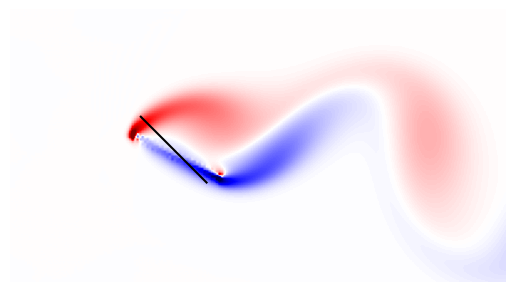

In [2]:
from matplotlib.colors import Normalize
from matplotlib import pyplot as plt

x = np.linspace(0, 599, 600)
y = np.linspace(0, 299, 300)
X, Y = np.meshgrid(x, y)
Z = 2*np.ones_like(X)

norm_sol = Normalize(vmin=-20, vmax=20)

H_sets = [90]
n_sets = len(H_sets)
ds = 1
N = 801
dt = 0.1
t = dt*np.arange(0, N)
dat_lst = []
N_trun = 200
extent = [0, nx, 0, ny]

for _h in H_sets:
    filename = str(data_dir) + f'/cached_data/omega_cube_phaseA_0_phaseH_{_h}.npy'
    vort = np.load(filename)[N_trun:]

unit = 600/16
x0 = 150 + unit/4
y0 = unit * 4

# Pitch
x1 = x0 - unit / 4 * np.cos(45*np.pi/180)
x2 = x0 + 3 * unit / 4 * np.cos(45*np.pi/180)
y1 = y0 + unit / 4 * np.sin(45*np.pi/180)
y2 = y0 - 3 * unit / 4 * np.sin(45*np.pi/180)


fig, ax = plt.subplots()
ax.axis('off')
snapshot_t = 30
ax.set_xlim([100, 300])
ax.set_ylim([90, 200])
ax.set_aspect("equal")
ax.set_xlabel("x", fontsize=12)
ax.set_ylabel("y", fontsize=12)

ax.imshow(vort[snapshot_t].reshape(ny, nx), norm=norm_sol, cmap='seismic', extent=extent)
ax.plot([x1, x2], [y1, y2], 'k-')
# fig.savefig(f'./journal_pics/ppplate_t_{snapshot_t}.png', bbox_inches='tight', dpi=600, transparent=True)

In [3]:
H_sets = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]
n_sets = len(H_sets)
ds = 1
N = 200
dt = 0.1
t = dt*np.arange(0, N)
dat_lst = []
N_trun = 200

for _h in H_sets:
    filename = str(data_dir) + f'/cached_data/omega_cube_phaseA_0_phaseH_{_h}.npy'
    vort = np.load(filename)[N_trun:]

    vort = vort.reshape(len(vort), -1)
    dat = vort[:N]
    dat_lst.append(dat)
dat_vstack = np.vstack(dat_lst)

u, s, vh = np.linalg.svd(dat_vstack, full_matrices=False)
uu = u @ np.diag(s)

u_lst2 = []
for _ in range(n_sets):
    _u = uu[_*N:(_+1)*N]
    u_lst2.append(_u)

Manifold info:
    No. of data points: 2400
    No. of ambient dim: 2400
    Estimated intrinsic dim: 3/2.9637197108941375
2**res.x * dmx = 12236.06375916307
    Reference bandwidth 23.945660810413695; ref L2 dist 205905.5474165694; ref scalar 0.059425614864121054


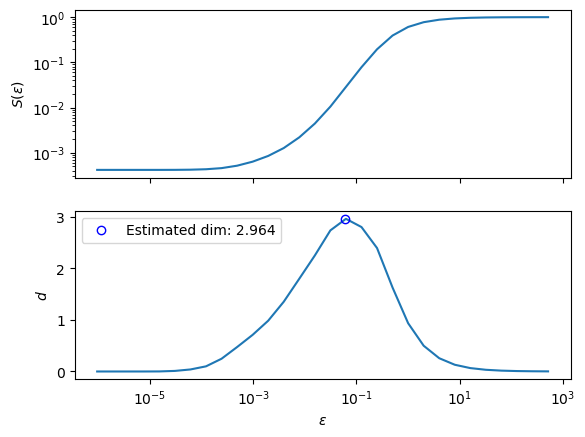

In [4]:
uu = u @ np.diag(s)

u_lst2 = []
for _ in range(n_sets):
    _u = uu[_*N:(_+1)*N]
    u_lst2.append(_u)
man = Manifold(np.vstack(u_lst2))
dim, (f, ax) = man.estimate_intrinsic_dim(bracket=[-20, 10], tol=0.2, ifplt=True)

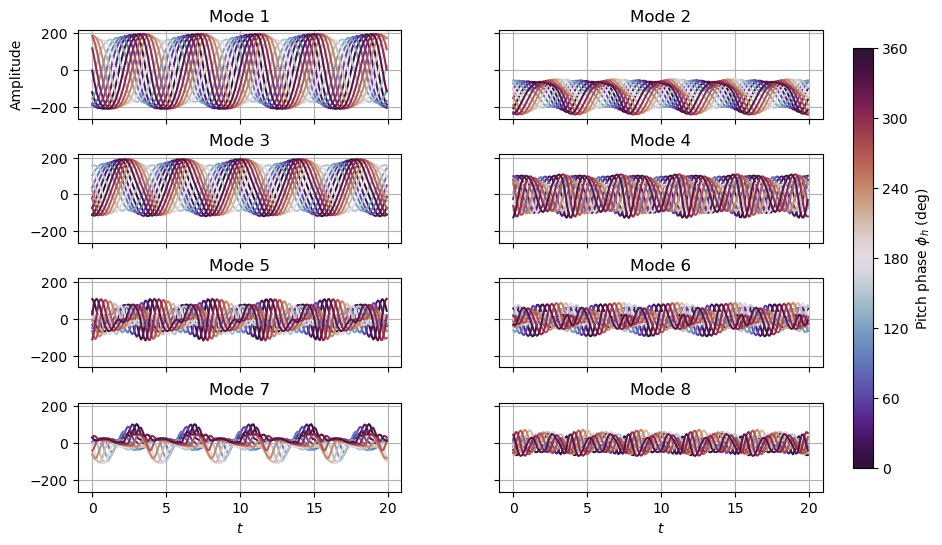

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.axes_grid1 import make_axes_locatable


H_arr = np.asarray(H_sets, dtype=float)
H_mod = np.mod(H_arr, 360.0)
norm  = colors.Normalize(vmin=0.0, vmax=360.0)
cmap  = cm.twilight_shifted

nModes = 8
rows = nModes // 2 + nModes % 2

fig, ax = plt.subplots(
    nrows=rows, ncols=2, sharex=True, sharey=True, figsize=(10, 6),
    constrained_layout=False
)
ax = np.atleast_2d(ax)

for m in range(nModes):
    r = m // 2
    c = m % 2
    for j in range(n_sets):
        col = cmap(norm(H_mod[j]))
        ax[r, c].plot(t, u_lst2[j][:, m], color=col, linewidth=1.5)
    ax[r, c].grid(True)
    ax[r, c].set_title(f"Mode {m+1}")

for c in range(2):
    ax[rows - 1, c].set_xlabel('$t$')
ax[0, 0].set_ylabel('Amplitude')

fig.subplots_adjust(right=0.87, wspace=0.3, hspace=0.4)
cax = fig.add_axes([0.9, 0.15, 0.02, 0.7])

mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
mappable.set_array([])
cb = plt.colorbar(mappable, cax=cax)
cb.set_label(r'Pitch phase $\phi_h$ (deg)')
cb.set_ticks(np.arange(0, 361, 60))

Text(0.5, 0, 'dim 3')

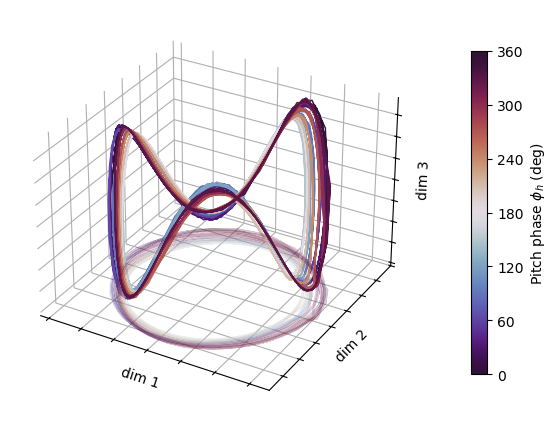

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from sklearn.manifold import Isomap

_u_vstack = np.vstack(u_lst2)

total_samples = _u_vstack.shape[0]
K_raw = int(np.sqrt(n_sets*N))
K = max(2, min(K_raw, total_samples - 1))

isom = Isomap(n_neighbors=K, n_components=3)
_X = isom.fit_transform(_u_vstack).T

std = np.std(_X, axis=1, keepdims=True)
std[std == 0] = 1.0
_X = _X / std

H_arr = np.asarray(H_sets, dtype=float)
H_mod = np.mod(H_arr, 360.0)
norm  = colors.Normalize(vmin=0.0, vmax=360.0)
cmap  = cm.twilight_shifted

fig = plt.figure(figsize=(7, 6))
ax = plt.axes(projection='3d')

X_lst = []
for i in range(n_sets):
    __X = _X[:, i*N:(i+1)*N]
    X_lst.append(__X)
    c = cmap(norm(H_mod[i]))
    ax.plot(*__X, color=c,  linewidth=1)
    ax.plot(__X[0], __X[1], -2*np.ones(__X.shape[-1]), color=c, alpha=0.25)

X_arr = np.array(X_lst)
n_segment_loop = 1
span = N // n_segment_loop

mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
mappable.set_array([])
cb = plt.colorbar(mappable, ax=ax, pad=0.1, shrink=0.7)
cb.set_label(r'Pitch phase $\phi_h$ (deg)')
cb.set_ticks(np.arange(0, 361, 60))

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

ax.set_xlabel("dim 1", labelpad=-8)
ax.set_ylabel("dim 2", labelpad=-8)
ax.set_zlabel("dim 3", labelpad=-8)

# fig.savefig('./pics/ppplate_isomap.png', bbox_inches='tight', dpi=600, transparent=True)

In [ ]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm, colors
from matplotlib.animation import FuncAnimation, FFMpegWriter, PillowWriter
from sklearn.manifold import Isomap

_u_vstack = np.vstack(u_lst2)
total_samples = _u_vstack.shape[0]
K_raw = int(np.sqrt(n_sets * N))
K = max(2, min(K_raw, total_samples - 1)) 

isom = Isomap(n_neighbors=K, n_components=3)
_X = isom.fit_transform(_u_vstack).T

std = np.std(_X, axis=1, keepdims=True)
std[std == 0] = 1.0
_X = _X / std

X_lst = []
for i in range(n_sets):
    __X = _X[:, i*N:(i+1)*N]
    X_lst.append(__X)
X_arr = np.array(X_lst)

H_arr = np.asarray(H_sets, dtype=float)
H_mod = np.mod(H_arr, 360.0)
norm  = colors.Normalize(vmin=0.0, vmax=360.0)
cmap  = cm.twilight_shifted

tail = 25
fps  = 5
dpi  = 140

fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection='3d')

for i in range(n_sets):
    c  = cmap(norm(H_mod[i]))
    Xi = X_arr[i]
    ax.plot(*Xi, color=c, linewidth=1.0, alpha=0.4)
    ax.plot(Xi[0], Xi[1], np.full(Xi.shape[-1], np.nanmin(X_arr[:,2,:]) - 0.05*(np.nanmax(X_arr[:,2,:]) - np.nanmin(X_arr[:,2,:]))),
            color=c, alpha=0.18)

points = []
tails  = []
for i in range(n_sets):
    c = cmap(norm(H_mod[i]))
    (pt,) = ax.plot([], [], [], marker='o', markersize=4.5, color=c, mec='k', mew=0.25)
    (tl,) = ax.plot([], [], [], color=c, linewidth=2.0)
    points.append(pt)
    tails.append(tl)

mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
mappable.set_array([])
cb = plt.colorbar(mappable, ax=ax, pad=0.1)
cb.set_label(r'Pitch phase $\phi_h$ (deg)')
cb.set_ticks(np.arange(0, 361, 60))

ax.set_xlim(np.nanmin(X_arr[:, 0, :]), np.nanmax(X_arr[:, 0, :]))
ax.set_ylim(np.nanmin(X_arr[:, 1, :]), np.nanmax(X_arr[:, 1, :]))
ax.set_zlim(np.nanmin(X_arr[:, 2, :]), np.nanmax(X_arr[:, 2, :]))
ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
ax.xaxis.set_pane_color((1,1,1,0)); ax.yaxis.set_pane_color((1,1,1,0)); ax.zaxis.set_pane_color((1,1,1,0))

plt.tight_layout()

N_frames = X_arr.shape[-1]

def naninterp_inplace(arr_1d):
    t = np.arange(arr_1d.size)
    m = np.isfinite(arr_1d)
    if m.any():
        arr_1d[~m] = np.interp(t[~m], t[m], arr_1d[m])
    else:
        arr_1d[:] = 0.0

if not np.isfinite(X_arr).all():
    X_arr = X_arr.copy()
    for i in range(n_sets):
        for d in range(3):
            naninterp_inplace(X_arr[i, d])

def init():
    for pt, tl in zip(points, tails):
        pt.set_data_3d([], [], [])
        tl.set_data_3d([], [], [])

    fig.suptitle("t = 1/{}".format(N_frames))
    return points + tails

def update(f):
    f0 = max(0, f - tail)
    for i, (pt, tl) in enumerate(zip(points, tails)):
        Xi = X_arr[i]  # (3, N)
        x, y, z = Xi[0, f], Xi[1, f], Xi[2, f]
        if np.isfinite(x) and np.isfinite(y) and np.isfinite(z):
            pt.set_data_3d([x], [y], [z])
            seg = Xi[:, f0:f+1]
            mask = np.all(np.isfinite(seg), axis=0)
            tl.set_data_3d(seg[0, mask], seg[1, mask], seg[2, mask])
        else:
            pt.set_data_3d([], [], [])
            tl.set_data_3d([], [], [])
    fig.suptitle(f"t = {f+1}/{N_frames}")
    return points + tails

anim = FuncAnimation(fig, update, frames=N_frames, init_func=init, blit=False, interval=1000/fps)

def save_animation(anim, base="./isomap_parallel", fps=30, dpi=140):
    try:
        if FFMpegWriter.isAvailable():
            writer = FFMpegWriter(fps=fps, bitrate=2400)
            outfile = f"{base}.mp4"
            anim.save(outfile, writer=writer, dpi=dpi)
            print("Saved", outfile)
            return
    except Exception:
        pass

    writer = PillowWriter(fps=fps)
    outfile = f"{base}.gif"
    anim.save(outfile, writer=writer, dpi=dpi)
    print("Saved", outfile)

save_animation(anim, base="./isomap_parallel", fps=fps, dpi=dpi)
plt.close(fig)


Saved ./isomap_parallel.gif


In [ ]:
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
from matplotlib import cm, colors
from matplotlib.animation import FuncAnimation, FFMpegWriter, PillowWriter
from sklearn.manifold import Isomap

# --- Build Isomap embedding (3D) ---
_u_vstack = np.vstack(u_lst2)            # (n_sets*N, D)
K = 25                                   # tune if needed
isom = Isomap(n_neighbors=K, n_components=3)
_X = isom.fit_transform(_u_vstack).T     # (3, n_sets*N)

# Normalize per axis (guard zero std)
std = np.std(_X, axis=1, keepdims=True)
std[std == 0] = 1.0
_X = _X / std

# Split into (n_sets, 3, N)
X_arr = np.array([_X[:, i*N:(i+1)*N] for i in range(n_sets)])  # (n_sets, 3, N)
N_frames = X_arr.shape[-1]

# Colors by pitch phase
H_arr = np.asarray(H_sets, dtype=float)
H_mod = np.mod(H_arr, 360.0)
norm  = colors.Normalize(vmin=0.0, vmax=360.0)
cmap  = cm.twilight_shifted

# Animation settings
tail = 25
fps  = 20          # slower playback than 30
dpi  = 140
base_azim = 35     # choose your favorite camera
base_elev = 20

# Figure with two 3D axes (rows)
fig = plt.figure(figsize=(8, 10))
ax1 = fig.add_subplot(2, 1, 1, projection='3d')
ax2 = fig.add_subplot(2, 1, 2, projection='3d')

# Helper to draw static context (full path + ground projection) on an axis
def draw_static(ax):
    zmin = np.nanmin(X_arr[:, 2, :])
    zmax = np.nanmax(X_arr[:, 2, :])
    zproj = zmin - 0.05 * (zmax - zmin)
    for i in range(n_sets):
        c  = cmap(norm(H_mod[i]))
        Xi = X_arr[i]  # (3, N)
        ax.plot(*Xi, color=c, linewidth=1.0, alpha=0.4)
        ax.plot(Xi[0], Xi[1], np.full(N_frames, zproj), color=c, alpha=0.18)

# Draw context on both axes
draw_static(ax1)
draw_static(ax2)

# Artists for both axes
pts1, tls1 = [], []
pts2, tls2 = [], []
for i in range(n_sets):
    c = cmap(norm(H_mod[i]))
    (p1,) = ax1.plot([], [], [], marker='o', markersize=4.5, color=c, mec='k', mew=0.25)
    (t1,) = ax1.plot([], [], [], color=c, linewidth=2.0)
    pts1.append(p1); tls1.append(t1)
    (p2,) = ax2.plot([], [], [], marker='o', markersize=4.5, color=c, mec='k', mew=0.25)
    (t2,) = ax2.plot([], [], [], color=c, linewidth=2.0)
    pts2.append(p2); tls2.append(t2)

# One colorbar for both axes
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
mappable.set_array([])
cb = fig.colorbar(mappable, ax=[ax1, ax2], pad=0.05, fraction=0.03)
cb.set_label(r'Pitch phase $\phi_h$ (deg)')
cb.set_ticks(np.arange(0, 361, 60))

# Finite limits + clean ticks
for ax in (ax1, ax2):
    ax.set_xlim(np.nanmin(X_arr[:, 0, :]), np.nanmax(X_arr[:, 0, :]))
    ax.set_ylim(np.nanmin(X_arr[:, 1, :]), np.nanmax(X_arr[:, 1, :]))
    ax.set_zlim(np.nanmin(X_arr[:, 2, :]), np.nanmax(X_arr[:, 2, :]))
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
    ax.xaxis.set_pane_color((1,1,1,0))
    ax.yaxis.set_pane_color((1,1,1,0))
    ax.zaxis.set_pane_color((1,1,1,0))

# Views: top original, bottom rotated +90° azimuth
ax1.view_init(elev=base_elev, azim=base_azim)
ax2.view_init(elev=base_elev, azim=base_azim + 90)

fig.tight_layout()

# Optional: interpolate any rare NaNs along time
def naninterp_inplace(y):
    t = np.arange(y.size)
    m = np.isfinite(y)
    if m.any():
        y[~m] = np.interp(t[~m], t[m], y[m])
    else:
        y[:] = 0.0

if not np.isfinite(X_arr).all():
    X_arr = X_arr.copy()
    for i in range(n_sets):
        for d in range(3):
            naninterp_inplace(X_arr[i, d])

def init():
    for p, t in zip(pts1, tls1):
        p.set_data_3d([], [], [])
        t.set_data_3d([], [], [])
    for p, t in zip(pts2, tls2):
        p.set_data_3d([], [], [])
        t.set_data_3d([], [], [])
    fig.suptitle(f"t = 1/{N_frames}")
    return pts1 + tls1 + pts2 + tls2

def _update_axis(ax_pts, ax_tls, f):
    f0 = max(0, f - tail)
    for i, (pt, tl) in enumerate(zip(ax_pts, ax_tls)):
        Xi = X_arr[i]  # (3, N)
        x, y, z = Xi[0, f], Xi[1, f], Xi[2, f]
        if np.isfinite(x) and np.isfinite(y) and np.isfinite(z):
            pt.set_data_3d([x], [y], [z])
            seg = Xi[:, f0:f+1]
            mask = np.all(np.isfinite(seg), axis=0)
            tl.set_data_3d(seg[0, mask], seg[1, mask], seg[2, mask])
        else:
            pt.set_data_3d([], [], [])
            tl.set_data_3d([], [], [])

def update(f):
    _update_axis(pts1, tls1, f)
    _update_axis(pts2, tls2, f)
    fig.suptitle(f"t = {f+1}/{N_frames}")
    return pts1 + tls1 + pts2 + tls2

anim = FuncAnimation(fig, update, frames=N_frames, init_func=init, blit=False, interval=1000/fps)

# Save helper: MP4 if ffmpeg is available, else GIF
def save_animation(anim, base="./isomap_dualview", fps=20, dpi=140):
    try:
        if FFMpegWriter.isAvailable():
            writer = FFMpegWriter(fps=fps, bitrate=2400)
            anim.save(f"{base}.mp4", writer=writer, dpi=dpi)
            print("Saved", f"{base}.mp4")
            return
    except Exception:
        pass
    writer = PillowWriter(fps=fps)
    anim.save(f"{base}.gif", writer=writer, dpi=dpi)
    print("Saved", f"{base}.gif")

save_animation(anim, base="./isomap_dualview", fps=fps, dpi=dpi)


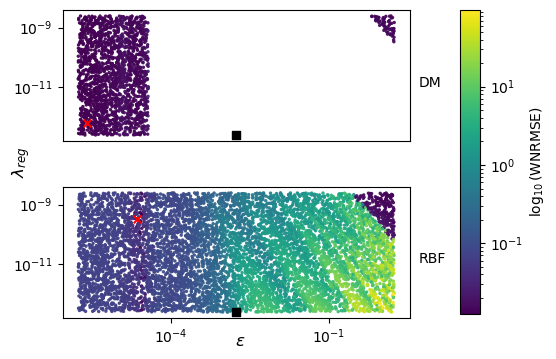

In [4]:
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib as mpl
from matplotlib.ticker import LogLocator

mode_lst = ["diffusion", "rbf"]
mode_labels = {"diffusion": "DM", "rbf": "RBF"}

map_type = "direct"

datasets, all_rmse_pos = [], []

for mode in mode_lst:
    cv = pl.read_parquet(model_dir + f"/ppplate/ppplate_cv_{mode}_{map_type}.parquet")
    datasets.append(cv)

    rmse = cv["rmse"].to_numpy()
    pos = np.isfinite(rmse) & (rmse > 0.0)
    if pos.any():
        all_rmse_pos.append(rmse[pos])

if not all_rmse_pos:
    raise ValueError("All RMSE values are NaN/inf or nonpositive; cannot use LogNorm.")

all_rmse_pos = np.concatenate(all_rmse_pos)
vmin, vmax = np.nanmin(all_rmse_pos), np.nanmax(all_rmse_pos)
cmap = "viridis"
norm = LogNorm(vmin=vmin, vmax=vmax)

fig, axs = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(5, 4),
    sharex=False, sharey=False
)

fig.subplots_adjust(right=0.82, wspace=0.25, hspace=0.35)

for i, (mode, cv) in enumerate(zip(mode_lst, datasets)):
    ax = axs[i]
    eps = cv["epsilon"].to_numpy()
    lam = cv["lambda"].to_numpy()
    rmse = cv["rmse"].to_numpy()

    eps_c = cv["epsilon_c"].to_numpy()[0]
    lam_m = cv["lambda_min"].to_numpy()[0]

    valid = np.isfinite(eps) & np.isfinite(lam) & np.isfinite(rmse) & (rmse > 0.0)

    ax.scatter(
        eps[valid], lam[valid],
        c=rmse[valid],
        cmap="viridis", norm=norm,
        s=6, alpha=0.95, edgecolors="none"
    )
    valid_eps = eps[valid]
    valid_lam = lam[valid]
    valid_rmse = rmse[valid]

    idx = np.nanargmin(valid_rmse)
    best_eps = valid_eps[idx]
    best_lam = valid_lam[idx]

    ax.scatter(best_eps, best_lam, c="red", s=30,
                    marker="x", zorder=3)
    ax.set_xscale("log")
    ax.set_yscale("log")

    ax.scatter(eps_c, 10**lam_m, c="black", marker='s', s=30, zorder=3)

    ax.set_ylabel(f"{mode_labels[mode]}", rotation=0, labelpad=6, ha="left")
    ax.yaxis.set_label_position("right")

x0 = fig.subplotpars.right + 0.1
cbar_ax = fig.add_axes([x0, 0.12, 0.04, 0.76])

sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar_ax.set_ylabel(r"$\log_{10}(\mathrm{WNRMSE})$")

fig.text(0.48, 0.04, r"$\epsilon$", ha="center", fontsize=12)
fig.text(0.02, 0.5, r"$\lambda_{reg}$", va="center", rotation="vertical", fontsize=12)

for ax in axs.flat:
    ax.tick_params(axis="x", which="both", bottom=False, labelbottom=False, top=False, labeltop=False)
    ax.tick_params(axis="y", which="both", left=False,  labelleft=False,  right=False, labelright=False)
    ax.minorticks_off()

x_locator = LogLocator(base=10, numticks=3)
y_locator = LogLocator(base=10, numticks=3)

for r in range(2):
    ax = axs[r]
    ax.tick_params(axis="y", which="both", left=True, labelleft=True)
    ax.yaxis.set_major_locator(y_locator)

axs[1].tick_params(axis="x", which="both", bottom=True, labelbottom=True)
axs[1].xaxis.set_major_locator(x_locator)

# fig.savefig("./journal_pics/ppplate_cv_results.png", bbox_inches="tight", dpi=600, transparent=True)

In [5]:
import pickle
import numpy as np

def optimalSig(s, thr=0.99):
    n = len(s)
    find = 0
    ind = 0
    _ = 0
    sigsum = np.cumsum(s**2)
    sig = sigsum / sigsum[-1]
    while (_ < n) and (find == 0):
        if sig[_] >= thr:
          ind = _
          find = 1
        _ = _ + 1
    return ind

dt = 0.1
map_type_lst = ["direct"]
mode_lst = ["diffusion", "rbf"]
title = "ppplate"

# data collection
training_sets = [30*i for i in range(12)]
validation_sets = [45, 225, 315]
n_training_sets = len(training_sets)
n_validation_sets = len(validation_sets)
test_sets = [135]

N = 200
N_trun = 200
N_test = 801
t = dt*np.arange(0, N)
training_dat_lst = []
for _i, _h in enumerate(training_sets):
    filename = data_dir + f'/cached_data/omega_cube_phaseA_0_phaseH_{_h}.npy'
    vort = np.load(filename)[N_trun:]

    vort = vort.reshape(len(vort), -1)
    _dat = vort[:N]
    training_dat_lst.append(_dat)
    
training_dat_vstack = np.vstack(training_dat_lst)
vortex_mean = np.mean(training_dat_vstack, axis=0)
training_dat_vstack = training_dat_vstack - vortex_mean
u, s, vh = np.linalg.svd(training_dat_vstack, full_matrices=False)
r = optimalSig(s, 0.991) + 1
ur, sr, vhr = u[:, :r], s[:r], vh[:r]
sr_norm = sr / sr[0]

data_train = ur @ np.diag(sr_norm)

print(f"svd order = {r}")

data_train_x, data_train_y = [], []
for _i, _h in enumerate(training_sets):
    _d = data_train[_i*N:(_i+1)*N]
    data_train_x.append(_d[:-1])
    data_train_y.append(_d[1:])

data_train_x, data_train_y = np.vstack(data_train_x), np.vstack(data_train_y)
print(f"data_train_x.shape = {data_train_x.shape}")
print(f"data_train_y.shape = {data_train_y.shape}")

validation_dat_lst = []
for _i, _h in enumerate(validation_sets):
    filename = data_dir + f'/cached_data/omega_cube_phaseA_0_phaseH_{_h}.npy'
    vort = np.load(filename)[N_trun:]

    vort = vort.reshape(len(vort), -1)
    vort = vort - vortex_mean
    _dat = vort[:N]
    validation_dat_lst.append(_dat)
validation_dat_vstack = np.vstack(validation_dat_lst)
validation_dat = validation_dat_vstack @ vhr.T @ np.diag(sr_norm/sr)

data_val = []
for _j in range(len(validation_sets)):
    data_val.append(validation_dat[_j*N:(_j+1)*N])

data_val = np.array(data_val)
data_val = data_val.transpose(1, 0, 2)
print(f"data_val.shape = {data_val.shape}")

# test data
test_dat_lst = []
for _i, _h in enumerate(test_sets):
    filename = data_dir + f'/cached_data/omega_cube_phaseA_0_phaseH_{_h}.npy'
    vort = np.load(filename)[N_trun:]

    vort = vort.reshape(len(vort), -1)
    vort = vort - vortex_mean
    _dat = vort[:N_test]
    test_dat_lst.append(_dat)
test_dat_vstack = np.vstack(test_dat_lst)
test_dat = test_dat_vstack @ vhr.T @ np.diag(sr_norm/sr)

svd order = 81
data_train_x.shape = (2388, 81)
data_train_y.shape = (2388, 81)
data_val.shape = (200, 3, 81)


In [6]:
import polars as pl
import numpy as np
try:
    import cupy as cp
    HAS_CUPY = True
except Exception:
    HAS_CUPY = False


def to_numpy_2d(obj):
    # Fast paths
    if HAS_CUPY and isinstance(obj, cp.ndarray):
        return cp.asnumpy(obj)
    if isinstance(obj, np.ndarray) and obj.dtype != object:
        return obj

    rows = [np.asarray(row, dtype=np.float64) for row in obj]
    return np.stack(rows, axis=0)


mode_lst = ["diffusion", "rbf"]
map_type = "direct"
path_lst = []
for mode in mode_lst:
    results_df = pl.read_parquet(
            model_dir + f"/ppplate/ppplate_{mode}_{map_type}.parquet"
        )
    
    path = to_numpy_2d(results_df["path"].to_list()[0])
    full_vortex_flow = path @ np.diag(sr/sr_norm) @ vhr
    path_lst.append(full_vortex_flow + vortex_mean)

dmd_order = 145
filename = str(model_dir) + f"/ppplate/ppplate_ResDMD_rank_{dmd_order}.npy"
path_lst.append(np.load(filename))

(100.0, 250.0, 110.0, 190.0)

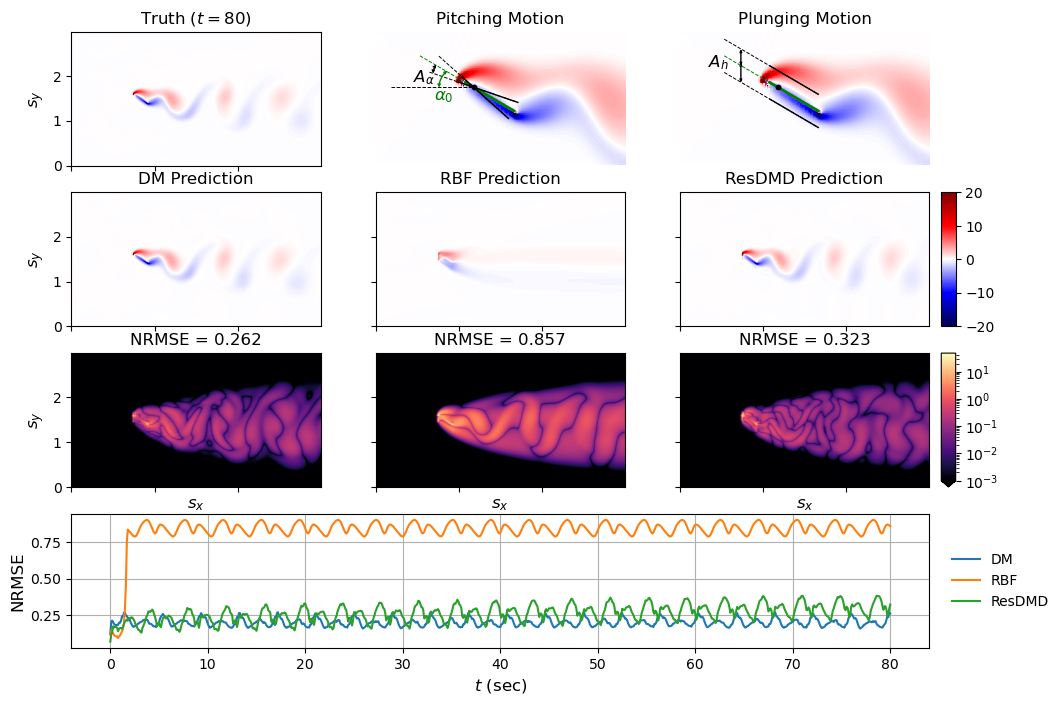

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm
from matplotlib.ticker import FuncFormatter


def add_row_colorbar(fig, row_axes, mappable, left=0.90, width=0.02, extend='neither'):
    bottoms = [ax.get_position().y0 for ax in row_axes]
    tops    = [ax.get_position().y1 for ax in row_axes]
    bottom  = min(bottoms)
    top     = max(tops)
    height  = top - bottom
    cax = fig.add_axes([left, bottom, width, height])
    return fig.colorbar(mappable, cax=cax, extend=extend)


def divide_by_100(x, pos):
    return f"{x/100:g}" 


"""

"""
scl_fac = 599/16
ffreq = 0.2549
tstep = 1000
a_offset =  0.5236 #+ 0.04
ang = 0.1 * np.sin(2*np.pi*ffreq*(0.1*tstep)) + a_offset
plg = 0.2 * np.sin(2*np.pi*ffreq*(0.1*tstep) + 150 * np.pi/180) * scl_fac

x0 = 159
y0 = 161
ycatt = y0 + plg

x1plate = x0 - 0.15 * scl_fac * np.cos(ang)
y1plate = ycatt + 0.15 * scl_fac * np.sin(ang)
x2plate = x0 + 0.75 * scl_fac * np.cos(ang)
y2plate = ycatt - 0.75* scl_fac* np.sin(ang)

x1ref = x0 - 1.00 * scl_fac * np.cos(ang)
y1ref = ycatt + 1.00 * scl_fac * np.sin(ang)
x2ref = x0 + 0.75 * scl_fac * np.cos(ang)
y2ref = ycatt - 0.75* scl_fac* np.sin(ang)

x1btm = x0 - 0.25 * scl_fac * np.cos(ang-0.2)
y1btm = ycatt + 0.25 * scl_fac * np.sin(ang-0.2)
x2btm = x0 + 0.75 * scl_fac * np.cos(ang-0.2)
y2btm = ycatt - 0.75 * scl_fac * np.sin(ang-0.2)

x1top = x0 - 0.25 * scl_fac * np.cos(ang+0.2)
y1top = ycatt + 0.25 * scl_fac * np.sin(ang+0.2)
x2top = x0 + 0.75 * scl_fac * np.cos(ang+0.2)
y2top = ycatt - 0.75 * scl_fac * np.sin(ang+0.2)

x1btmref = x0 - 0.75 * scl_fac * np.cos( ang -0.2)
y1btmref = ycatt + 0.75 * scl_fac * np.sin( ang -0.2)
x2btmref = x0 + 0.75 * scl_fac * np.cos( ang -0.2)
y2btmref = ycatt - 0.75 * scl_fac * np.sin( ang -0.2)

x1topref = x0 - 0.75 * scl_fac * np.cos( ang +0.2)
y1topref = ycatt + 0.75 * scl_fac * np.sin( ang +0.2)
x2topref = x0 + 0.75 * scl_fac * np.cos( ang +0.2)
y2topref = ycatt - 0.75 * scl_fac * np.sin( ang +0.2)

nx = 599
ny = 299

fontsize=12

truth_flat   = test_dat_lst[0][-1] + vortex_mean
dm_flat      = path_lst[0][-1]
rbf_flat     = path_lst[1][-1]
resdmd_flat  = path_lst[2][-1]

truth           = truth_flat.reshape(ny, nx)

pred_dm         = dm_flat.reshape(ny, nx)
pred_rbf        = rbf_flat.reshape(ny, nx)
pred_resdmd     = resdmd_flat.reshape(ny, nx)

error_dm_t      = np.abs(test_dat_lst[0] + vortex_mean - path_lst[0])
error_rbf_t     = np.abs(test_dat_lst[0] + vortex_mean - path_lst[1])
error_resdmd_t  = np.abs(test_dat_lst[0] + vortex_mean - path_lst[2])

error_dm  = np.abs(truth - pred_dm)
error_rbf = np.abs(truth - pred_rbf)
error_resdmd = np.abs(truth - pred_resdmd)

nrmse_dm_t  = np.linalg.norm(error_dm_t.T, axis=0) / np.linalg.norm((test_dat_lst[0]+vortex_mean).T, axis=0)
nrmse_rbf_t  = np.linalg.norm(error_rbf_t.T, axis=0) / np.linalg.norm((test_dat_lst[0]+vortex_mean).T, axis=0)
nrmse_resdmd_t  = np.linalg.norm(error_resdmd_t.T, axis=0) / np.linalg.norm((test_dat_lst[0]+vortex_mean).T, axis=0)

norm_sol = Normalize(vmin=-20, vmax=20)

all_err = np.stack([error_dm, error_rbf, error_resdmd], axis=0)
err_min_pos = np.nanmin(all_err[all_err > 0])
vmax_err = float(np.nanmax(all_err))
max_err_cap  = vmax_err
min_err_cap = 1e-3

norm_err = LogNorm(vmin=min_err_cap, vmax=max_err_cap)
cmap_err = plt.cm.magma.copy()
cmap_err.set_over(cmap_err(1.0))

extent = [0, nx, 0, ny]

fig = plt.figure(figsize=(12, 8))
gs  = fig.add_gridspec(nrows=4, ncols=3, right=0.84, hspace=0.20, wspace=0.22)
bt_ax = fig.add_subplot(gs[3, :])

ax_truth    = fig.add_subplot(gs[0, 0])
ax_pitch    = fig.add_subplot(gs[0, 1])
ax_plunge   = fig.add_subplot(gs[0, 2])

ax_dm       = fig.add_subplot(gs[1, 0], sharex=ax_truth, sharey=ax_truth)
ax_rbf      = fig.add_subplot(gs[1, 1], sharex=ax_truth, sharey=ax_truth)
ax_resdmd   = fig.add_subplot(gs[1, 2], sharex=ax_truth, sharey=ax_truth)
ax_dm_err   = fig.add_subplot(gs[2, 0], sharex=ax_truth, sharey=ax_truth)
ax_rbf_err  = fig.add_subplot(gs[2, 1], sharex=ax_truth, sharey=ax_truth)
ax_resdmd_err = fig.add_subplot(gs[2, 2], sharex=ax_truth, sharey=ax_truth)

im_truth = ax_truth.imshow(truth,   norm=norm_sol, cmap='seismic', aspect='auto', extent=extent)
im_pitch = ax_pitch.imshow(truth,   norm=norm_sol, cmap='seismic', extent=extent)
im_plunge = ax_plunge.imshow(truth,   norm=norm_sol, cmap='seismic', extent=extent)

im_dm    = ax_dm.imshow(pred_dm,    norm=norm_sol, cmap='seismic', aspect='auto', extent=extent)
im_rbf   = ax_rbf.imshow(pred_rbf,  norm=norm_sol, cmap='seismic', aspect='auto', extent=extent)
im_resdmd   = ax_resdmd.imshow(pred_resdmd,  norm=norm_sol, cmap='seismic', aspect='auto', extent=extent)

error_dm[error_dm < min_err_cap] = min_err_cap
error_rbf[error_rbf < min_err_cap] = min_err_cap
error_resdmd[error_resdmd < min_err_cap] = min_err_cap

im_dm_err  = ax_dm_err.imshow(error_dm,  cmap=cmap_err, norm=norm_err, aspect='auto', extent=extent)
im_rbf_err = ax_rbf_err.imshow(error_rbf, cmap=cmap_err, norm=norm_err, aspect='auto', extent=extent)
im_resdmd_err = ax_resdmd_err.imshow(error_resdmd, cmap=cmap_err, norm=norm_err, aspect='auto', extent=extent)

# axis cosmetics
for _ax in (ax_truth, ax_dm, ax_rbf, ax_resdmd, ax_dm_err, ax_rbf_err, ax_resdmd_err):
    _ax.set_xlim(0, nx)
    _ax.set_ylim(0, ny)
    _ax.label_outer()
    _ax.xaxis.set_major_formatter(FuncFormatter(divide_by_100))
    _ax.yaxis.set_major_formatter(FuncFormatter(divide_by_100))

ax_truth.set_title("Truth " + "$(t = 80)$")
ax_pitch.set_title("Pitching Motion")
ax_plunge.set_title("Plunging Motion")
ax_dm.set_title("DM Prediction")
ax_rbf.set_title("RBF Prediction")
ax_resdmd.set_title("ResDMD Prediction")

ax_dm_err.set_title(f"NRMSE = {nrmse_dm_t[-1]:.3g}")
ax_rbf_err.set_title(f"NRMSE = {nrmse_rbf_t[-1]:.3g}")
ax_resdmd_err.set_title(f"NRMSE = {nrmse_resdmd_t[-1]:.3g}")

ax_truth.set_ylabel("$s_y$", fontsize=fontsize)
ax_dm.set_ylabel("$s_y$", fontsize=fontsize)
ax_dm_err.set_ylabel("$s_y$", fontsize=fontsize)
ax_dm_err.set_xlabel("$s_x$", fontsize=fontsize)
ax_rbf_err.set_xlabel("$s_x$", fontsize=fontsize)
ax_resdmd_err.set_xlabel("$s_x$", fontsize=fontsize)

def add_aligned_cbar(fig, mappable, *, bottom, top, left, width, label=None, extend=None, nbins=6):

    cax = fig.add_axes([left, bottom, width, top - bottom])
    cb = fig.colorbar(mappable, cax=cax, extend=extend)
    if label:
        cb.set_label(label, rotation=270, labelpad=18)
    from matplotlib.ticker import MaxNLocator, ScalarFormatter
    cb.locator = MaxNLocator(nbins=nbins, prune=None, steps=[1, 2, 2.5, 5, 10])
    fmt = ScalarFormatter(useMathText=True)
    fmt.set_powerlimits((-2, 3))
    cb.formatter = fmt
    cb.update_ticks()
    return cb


fig.canvas.draw()
all_axes = [ax_truth, ax_pitch, ax_plunge, 
            ax_dm, ax_rbf, ax_resdmd, 
            ax_dm_err, ax_rbf_err, ax_resdmd_err]

bottoms = [ax.get_position().y0 for ax in all_axes]
tops    = [ax.get_position().y1 for ax in all_axes]
cb_bottom = min(bottoms)
cb_top    = max(tops)

cb_width = 0.018
cb1_left = 0.86 
cb2_left = 0.885

row0_axes = [ax_truth]
row2_axes = [ax_dm, ax_rbf, ax_resdmd]
row3_axes = [ax_dm_err, ax_rbf_err, ax_resdmd_err]


# cb0 = add_row_colorbar(fig, row0_axes, im_truth,   left=0.85, width=0.012)
cb2 = add_row_colorbar(fig, row2_axes, im_dm, left=0.85, width=0.012)
cb3 = add_row_colorbar(fig, row3_axes, im_dm_err, left=0.85, width=0.012, extend="min")

ax_truth.set_yticks([0, 100, 200])
ax_truth.tick_params(axis='y', which='both', labelleft=True)
ax_truth.set_yticklabels(['0', '1', '2'])
ax_truth.tick_params(axis='y', which='both', labelleft=True)



t_plot = dt*np.arange(0, len(nrmse_dm_t))
l1, = bt_ax.plot(t_plot, nrmse_dm_t)
l2, = bt_ax.plot(t_plot, nrmse_rbf_t)
l3, = bt_ax.plot(t_plot, nrmse_resdmd_t)
bt_ax.set_xlabel('$t$ (sec)', fontsize=fontsize)
bt_ax.set_ylabel('NRMSE', fontsize=fontsize)
bt_ax.grid()
bt_ax.legend(
    [l1, l2, l3],
    ['DM', 'RBF', 'ResDMD'],
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),
    borderaxespad=0.0,
    frameon=False
)


"""
    pitch
"""
ax_pitch.set_xlim([100, 250])
ax_pitch.set_ylim([110, 190])
ax_pitch.axis('off')

ax_pitch.plot([x1ref, x2ref], [y1ref, y2ref], 'g--', linewidth=0.7)
ax_pitch.plot([x1plate, x2plate], [y1plate, y2plate], 'g-', linewidth=2)

ax_pitch.plot([x1btm, x2btm], [y1btm, y2btm], 'k-', linewidth=1.0)
ax_pitch.plot([x1btmref, x2btmref], [y1btmref, y2btmref], 'k--', linewidth=0.7)
ax_pitch.plot([x1top, x2top], [y1top, y2top], 'k-', linewidth=1.0)
ax_pitch.plot([x1topref, x2topref], [y1topref, y2topref], 'k--', linewidth=0.7)
ax_pitch.scatter(x0, ycatt, c='k', s=10, zorder=10)
ax_pitch.plot([x0-50,x0], [ycatt, ycatt], 'k--', linewidth=0.7)


ax_pitch.annotate('', xy=(x1btmref+12, y1btmref+2), xytext=(138, y0-6),
             arrowprops={'arrowstyle':'<->', 'connectionstyle':'arc3,rad=-0.25', 'color':'g', 'mutation_scale': 4}
             ,horizontalalignment='center', color='green')
ax_pitch.annotate('',xy=(x1ref+11, y1ref-4), xytext=(x1btmref+2.3, y1btmref-2.5),
             arrowprops={'arrowstyle':'<->', 'connectionstyle':'arc3,rad=-0.25', 'color':'k', 'mutation_scale': 4}
             ,horizontalalignment='center')
ax_pitch.text(x=135, y=149, s=r"$\alpha_0$", fontsize=12, color='g')
ax_pitch.text(x=x1btmref-10, y=y1btmref-6, s=r"$A_{\alpha}$", fontsize=12, color='k')

"""
    plunge
"""
import matplotlib.patches as mpatches

ax_plunge.plot([x1ref, x2ref], [y1ref, y2ref], 'g--', linewidth=0.7)
ax_plunge.plot([x1plate, x2plate], [y1plate, y2plate], 'g-', linewidth=2)
ax_plunge.scatter(x0, ycatt, c='k', s=10, zorder=10)

ax_plunge.plot([x1ref, x2ref], [y1ref+10, y2ref+10], 'k--', linewidth=0.7)
ax_plunge.plot([x1ref, x2ref], [y1ref-10, y2ref-10], 'k--', linewidth=0.7)

ax_plunge.plot([x1plate, x2plate], [y1plate+10, y2plate+10], 'k-', linewidth=1.0)
ax_plunge.plot([x1plate, x2plate], [y1plate-10, y2plate-10], 'k-', linewidth=1.0)

arr1 = mpatches.FancyArrowPatch((x1ref+10, y1ref+6), (x1ref+10, y1ref-8),
                               arrowstyle='<->,head_width=.15', mutation_scale=4, color='k')
arr2 = mpatches.FancyArrowPatch((x1ref+10, y1ref-2), (x1ref+10, y1ref-18),
                               arrowstyle='<->,head_width=.15', mutation_scale=4, color='k')
ax_plunge.add_patch(arr1)
ax_plunge.add_patch(arr2)
ax_plunge.text(x=x1ref-10, y=y1ref-7, s=r"$A_h$", fontsize=12, color='k')


ax_plunge.set_xlim([100, 250])
ax_plunge.set_ylim([110, 190])
ax_plunge.axis('off')

fig.savefig('./pics/ppplate_results.png', 
            bbox_inches='tight', 
            dpi=600, 
            transparent=True)

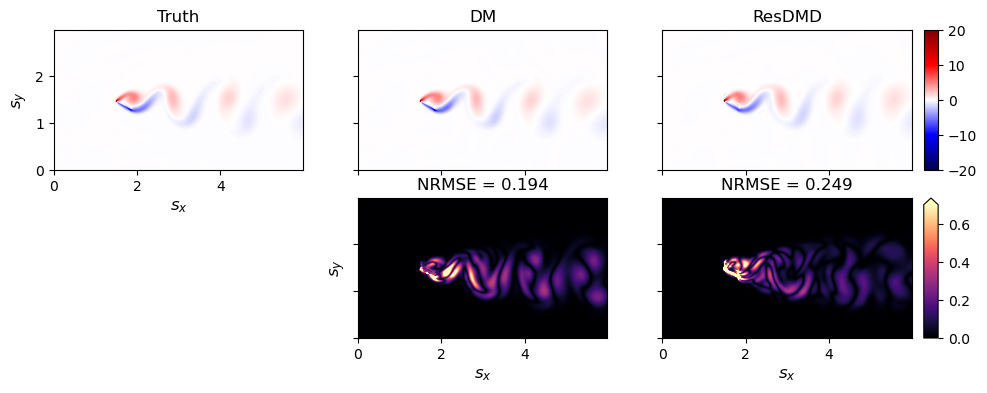

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm
from matplotlib.ticker import FuncFormatter


def add_row_colorbar(fig, row_axes, mappable, left=0.90, width=0.02, extend='neither'):
    bottoms = [ax.get_position().y0 for ax in row_axes]
    tops    = [ax.get_position().y1 for ax in row_axes]
    bottom  = min(bottoms)
    top     = max(tops)
    height  = top - bottom
    cax = fig.add_axes([left, bottom, width, height])
    return fig.colorbar(mappable, cax=cax, extend=extend)


def divide_by_100(x, pos):
    return f"{x/100:g}" 


nx = 599
ny = 299

fontsize = 12

# step_show = 30
# step_show = 30 + 392
step_show = 30 + 745

truth_flat   = test_dat_lst[0][step_show] + vortex_mean      # (ny*nx,)
dm_flat      = path_lst[0][step_show]                        # (ny*nx,)
resdmd_flat  = path_lst[2][step_show]

truth           = truth_flat.reshape(ny, nx)

pred_dm         = dm_flat.reshape(ny, nx)
pred_resdmd     = resdmd_flat.reshape(ny, nx)

error_dm_t      = np.abs(truth_flat - dm_flat)
error_resdmd_t  = np.abs(truth_flat - resdmd_flat)

error_dm  = np.abs(truth - pred_dm)
error_resdmd = np.abs(truth - pred_resdmd)

nrmse_dm  = np.linalg.norm(error_dm_t)  / np.linalg.norm(truth_flat)
nrmse_resdmd = np.linalg.norm(error_resdmd_t) / np.linalg.norm(truth_flat)

norm_sol = Normalize(vmin=-20, vmax=20)

all_err = np.stack([error_dm, error_resdmd], axis=0)
err_min_pos = np.nanmin(all_err[all_err > 0])
vmax_err = float(np.nanmax(all_err))
max_err_cap  = vmax_err

err_cap  = 0.05 * vmax_err
norm_err = Normalize(vmin=0.0, vmax=err_cap)

cmap_err = plt.cm.magma.copy()
cmap_err.set_over(cmap_err(1.0))

extent = [0, nx, 0, ny]

fig = plt.figure(figsize=(12, 4))
gs  = fig.add_gridspec(nrows=2, ncols=3, right=0.84, hspace=0.20, wspace=0.22)

ax_truth    = fig.add_subplot(gs[0, 0])

ax_dm       = fig.add_subplot(gs[0, 1], sharex=ax_truth, sharey=ax_truth)
ax_resdmd   = fig.add_subplot(gs[0, 2], sharex=ax_truth, sharey=ax_truth)
ax_dm_err   = fig.add_subplot(gs[1, 1], sharex=ax_truth, sharey=ax_truth)
ax_resdmd_err = fig.add_subplot(gs[1, 2], sharex=ax_truth, sharey=ax_truth)

im_truth = ax_truth.imshow(truth,   norm=norm_sol, cmap='seismic', aspect='auto', extent=extent)
im_dm    = ax_dm.imshow(pred_dm,    norm=norm_sol, cmap='seismic', aspect='auto', extent=extent)
im_resdmd   = ax_resdmd.imshow(pred_resdmd,  norm=norm_sol, cmap='seismic', aspect='auto', extent=extent)

im_dm_err  = ax_dm_err.imshow(error_dm,  cmap=cmap_err, norm=norm_err, aspect='auto', extent=extent)
im_resdmd_err = ax_resdmd_err.imshow(error_resdmd, cmap=cmap_err, norm=norm_err, aspect='auto', extent=extent)

for _ax in (ax_truth, ax_dm, ax_resdmd, ax_dm_err, ax_resdmd_err):
    _ax.set_xlim(0, nx)
    _ax.set_ylim(0, ny)
    _ax.label_outer()
    _ax.xaxis.set_major_formatter(FuncFormatter(divide_by_100))
    _ax.yaxis.set_major_formatter(FuncFormatter(divide_by_100))

ax_truth.set_title("Truth")
ax_dm.set_title("DM")
ax_resdmd.set_title("ResDMD")

ax_dm_err.set_title(f"NRMSE = {nrmse_dm:.3g}")
ax_resdmd_err.set_title(f"NRMSE = {nrmse_resdmd:.3g}")

ax_truth.set_ylabel("$s_y$", fontsize=fontsize)
ax_truth.set_xlabel("$s_x$", fontsize=fontsize)
ax_dm_err.set_ylabel("$s_y$", fontsize=fontsize)
ax_dm_err.set_xlabel("$s_x$", fontsize=fontsize)
ax_resdmd_err.set_xlabel("$s_x$", fontsize=fontsize)

def add_aligned_cbar(fig, mappable, *, bottom, top, left, width, label=None, extend=None, nbins=6):

    cax = fig.add_axes([left, bottom, width, top - bottom])
    cb = fig.colorbar(mappable, cax=cax, extend=extend)
    if label:
        cb.set_label(label, rotation=270, labelpad=18)

    from matplotlib.ticker import MaxNLocator, ScalarFormatter
    cb.locator = MaxNLocator(nbins=nbins, prune=None, steps=[1, 2, 2.5, 5, 10])
    fmt = ScalarFormatter(useMathText=True)
    fmt.set_powerlimits((-2, 3))
    cb.formatter = fmt
    cb.update_ticks()
    return cb


row2_axes = [ax_dm, ax_resdmd]
row3_axes = [ax_dm_err, ax_resdmd_err]

cb2 = add_row_colorbar(fig, row2_axes, im_dm, left=0.85, width=0.012)
cb3 = add_row_colorbar(fig, row3_axes, im_dm_err, left=0.85, width=0.012, extend="max")

ax_truth.tick_params(axis='y', which='both', labelleft=True)
ax_truth.tick_params(axis='x', which='both', labelbottom=True)
ax_truth.set_yticks([0, 100, 200])
ax_truth.set_yticklabels(['0', '1', '2'])

fig.savefig(f'./pics/ppplate_results_step_{step_show}.png', 
            bbox_inches='tight', 
            dpi=600, 
            transparent=True)
